<a href="https://colab.research.google.com/github/barzansaeedpour/PyTorch-for-DeepLearning/blob/main/02_PyTorch_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Make classification data and get it ready

In [1]:
import sklearn
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.datasets import make_circles


# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state= 42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of x:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of x:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [5]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})

In [6]:
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


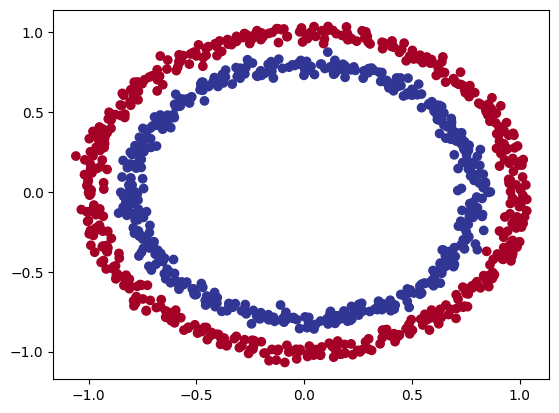

In [7]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)


### 1.1 Check input and output shapes

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

### 1.2 Turn data into tensors and create train and test splits

In [9]:
# Turn data into tensors
import torch
torch.__version__

'2.2.1+cu121'

In [10]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

The default type for numpy as float64, but the default type for PyTorch Tensor is float32:

In [11]:
X = torch.from_numpy(X).type(torch.float)
# X = torch.from_numpy(X).type(torch.float32) # the same as above
y = torch.from_numpy(y).type(torch.float)

In [12]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [13]:
type(X), X.dtype , y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [14]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size= 0.2,
                                                    random_state= 42)


In [15]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:

1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one
2. Construc a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [16]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [17]:
X_train.shape

torch.Size([800, 2])

Now we've setup device agnostic code, let's create a model that:

1. Subclass `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create two `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass (or forward computation of the model)
4. Instantiate an instanse of our model class and send it to the target device


In [18]:
# 1. Contruct a model that subclasses nn.Module
class CircleModelV0(nn.Module):

    def __init__(self):
        super().__init__()
        # 2. Create two nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features = 2, out_features= 5) # takes in 2 features and upscales to 5 features
        self.layer_2 = nn.Linear(in_features = 5, out_features= 1)

    # 3. Define a forward() method that outlines the forward pass
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
device

'cpu'

In [20]:
next(model_0.parameters()).device

device(type='cpu')

Another way to build a neural network model

In [21]:
# let's replicate the model above using nn.Sequential()
model_0 = nn. Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [22]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.4340,  0.0508],
                      [-0.4249,  0.0768],
                      [-0.3825, -0.2781],
                      [-0.0621, -0.5082],
                      [ 0.5163,  0.4408]])),
             ('0.bias', tensor([-0.0213, -0.6741, -0.3908,  0.1951, -0.6055])),
             ('1.weight',
              tensor([[ 0.2442,  0.4194,  0.3852, -0.3972, -0.4446]])),
             ('1.bias', tensor([-0.2743]))])

In [23]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions: \n {untrained_preds[:10]}")
print(f"\nFirst 10  labels:\n {y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions: 
 tensor([[-0.4004],
        [-0.5819],
        [-0.2049],
        [-0.4546],
        [-0.6497],
        [-0.7570],
        [-0.9154],
        [-0.9576],
        [-0.1864],
        [-0.5990]])

First 10  labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [24]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### 2.1 setup loss function and optimizer

which loss function or optimizer should we use?

this is a problem specific.

For example for regression we might want MAE of MSE (man absolute error or mean squerd error).

For classification we might want binary cross entropy or categorical cross entropy (cross entropy).

In [25]:
# Setup the loss function
# loss_fn = nn.BCELoss() # BCELoss = requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss()  # BCEWithLogitsLoss = sigmoid activation function built-in

optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr=0.1)

In [26]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # eq() stands for equal and item() turns it to a single value
    acc = (correct/len(y_pred)) * 100
    return acc

## 3. Train model

To train our model, we're going to need to build a training loop with the following steps:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step(gradient descent)


### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**. (logits are the raw outputs of our model without being passed to any activation function)

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification)

Then we can covert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`.

In [27]:
# View the first 5 outputs of forwads pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.4004],
        [-0.5819],
        [-0.2049],
        [-0.4546],
        [-0.6497]])

In [28]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [29]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4012],
        [0.3585],
        [0.4490],
        [0.3883],
        [0.3431]])

For our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [30]:
# Find the predicted labels (coverting the probabilties to labels)
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()


tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.])

### 3.2 Building a training and testing loop

In [31]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2. Calculate loss / accuracy

    # if the loss_fn is nn.BCELoss, we need to use this loss function:
    # loss = loss_fn(torch.sigmoid(y_logits), y_train) # nn.BCELoss expects prediction probabilities as input

    # if the loss_fn is nn.BCEWithLogitsLoss, we need to use this loss function:
    loss = loss_fn(y_logits, y_train)  # nn.BCEWithLogitsLoss expects raw logits as input

    acc = accuracy_fn(y_true = y_train,
                      y_pred = y_pred )

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate the loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_test,
                               y_pred = test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")




Epoch: 0 | Loss: 0.73650, Acc: 50.00% | Test Loss: 0.72602, Test acc: 50.00%
Epoch: 10 | Loss: 0.70941, Acc: 44.12% | Test Loss: 0.70253, Test acc: 48.50%
Epoch: 20 | Loss: 0.70109, Acc: 47.62% | Test Loss: 0.69574, Test acc: 51.50%
Epoch: 30 | Loss: 0.69792, Acc: 48.50% | Test Loss: 0.69360, Test acc: 49.50%
Epoch: 40 | Loss: 0.69636, Acc: 49.12% | Test Loss: 0.69290, Test acc: 50.00%
Epoch: 50 | Loss: 0.69541, Acc: 49.00% | Test Loss: 0.69271, Test acc: 50.50%
Epoch: 60 | Loss: 0.69476, Acc: 49.75% | Test Loss: 0.69273, Test acc: 50.00%
Epoch: 70 | Loss: 0.69430, Acc: 49.88% | Test Loss: 0.69284, Test acc: 49.00%
Epoch: 80 | Loss: 0.69397, Acc: 50.12% | Test Loss: 0.69300, Test acc: 47.50%
Epoch: 90 | Loss: 0.69372, Acc: 50.12% | Test Loss: 0.69317, Test acc: 49.50%


## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything...

So to inspect it let's make some predictions and make it visual!

To do so, we're going to make a function called `plot_decision_boundry()`

In [32]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

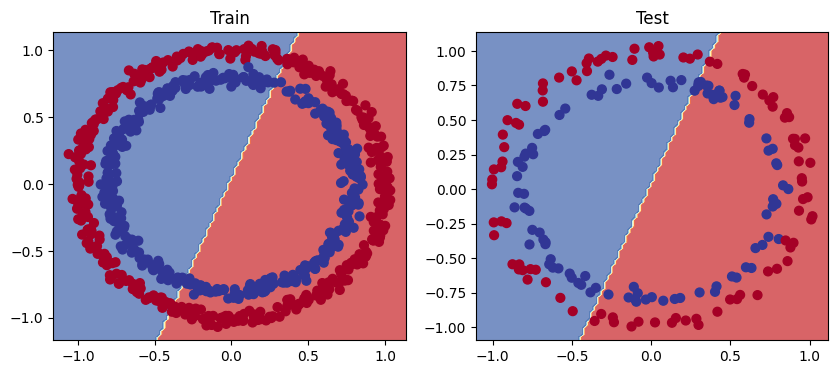

In [33]:
# Plot decision boundry of the model
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model(from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

These options are all from a model's perspective because they deal directly with the model, rather than the data.

And because these options are all values we (as machine learning engineers and data scientisits) can change, they are referred as **hyperparameters**

Let's try and improve our model by:

* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

In [34]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [35]:
# Create loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr=0.1)

In [36]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_1.train()

    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2. Calculate loss / accuracy

    # if the loss_fn is nn.BCELoss, we need to use this loss function:
    # loss = loss_fn(torch.sigmoid(y_logits), y_train) # nn.BCELoss expects prediction probabilities as input

    # if the loss_fn is nn.BCEWithLogitsLoss, we need to use this loss function:
    loss = loss_fn(y_logits, y_train)  # nn.BCEWithLogitsLoss expects raw logits as input

    acc = accuracy_fn(y_true = y_train,
                      y_pred = y_pred )

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate the loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_test,
                               y_pred = test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")




Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test Loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Acc: 50.38% | Test Loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Acc: 51.12% | Test Loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Acc: 51.62% | Test Loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Acc: 51.12% | Test Loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test acc: 46.00%


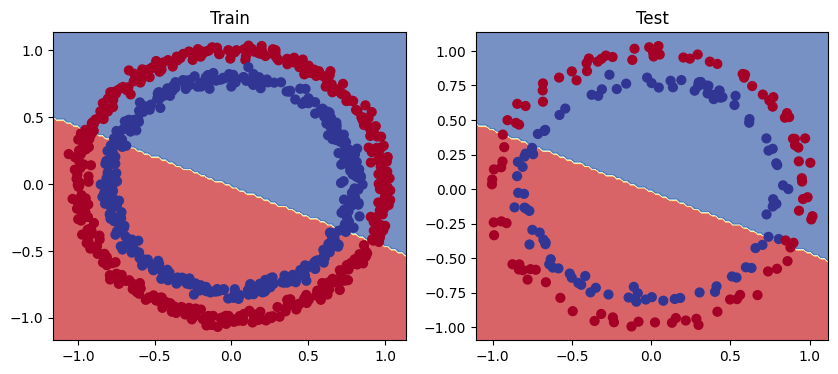

In [37]:
# Plot decision boundry of the model
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a strainght line

One way to troubleshoot to a larger problem is to test out a smaller problem.

In [38]:
# Create some data
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim = 1) # without unsqueeze, errors will pop up
y_regression = weight * X_regression + bias # Linear regression formula (without epsilon)
X_regression[:10], y_regression[:10]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400],
         [0.0500],
         [0.0600],
         [0.0700],
         [0.0800],
         [0.0900]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280],
         [0.3350],
         [0.3420],
         [0.3490],
         [0.3560],
         [0.3630]]))

In [39]:
#  Split data
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

(80, 80, 20, 20)

In [40]:
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(8, 5))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 12})

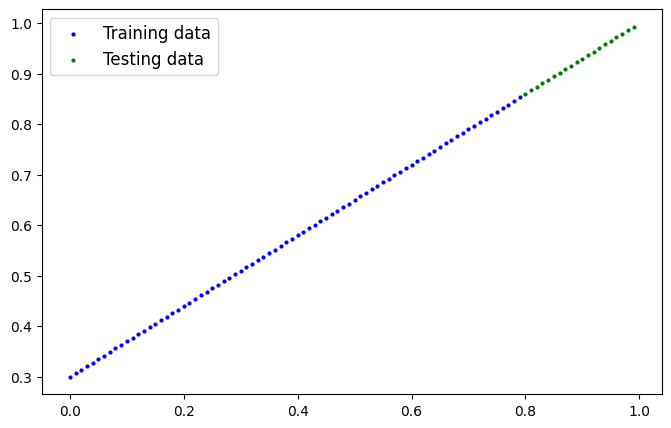

In [41]:
plot_predictions(    train_data = X_train_regression, train_labels= y_train_regression, test_data = X_test_regression, test_labels= y_test_regression)

### 5.2 Adjusting `model_1` to fit a straight line

In [42]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1),
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [43]:
# Create loss function
loss_fn = nn.L1Loss()

# Create an optimizer
optimizer = torch.optim.SGD(params = model_2.parameters(),
                            lr=0.01)

In [44]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}| Test Loss: {test_loss:.5f}")




Epoch: 0 | Loss: 0.75986| Test Loss: 0.91103
Epoch: 100 | Loss: 0.02858| Test Loss: 0.00081
Epoch: 200 | Loss: 0.02533| Test Loss: 0.00209
Epoch: 300 | Loss: 0.02137| Test Loss: 0.00305
Epoch: 400 | Loss: 0.01964| Test Loss: 0.00341
Epoch: 500 | Loss: 0.01940| Test Loss: 0.00387
Epoch: 600 | Loss: 0.01903| Test Loss: 0.00379
Epoch: 700 | Loss: 0.01878| Test Loss: 0.00381
Epoch: 800 | Loss: 0.01840| Test Loss: 0.00329
Epoch: 900 | Loss: 0.01798| Test Loss: 0.00360


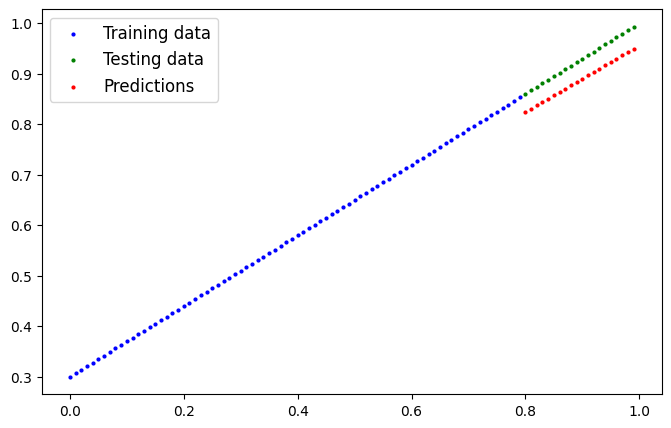

In [45]:
model_2.eval()

with torch.inference_mode():
    y_preds = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

## 6. The missing piece: non-linearity

### 6.1 Building a model with non-linearity

Artificial neural networds are a large combination of linear (straight) and non-straight functions which are potentially able to find patterns in data.


In [46]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [47]:
# Create loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params = model_3.parameters(),
                            lr=0.1)

In [48]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_3.train()

    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2. Calculate loss / accuracy

    # if the loss_fn is nn.BCELoss, we need to use this loss function:
    # loss = loss_fn(torch.sigmoid(y_logits), y_train) # nn.BCELoss expects prediction probabilities as input

    # if the loss_fn is nn.BCEWithLogitsLoss, we need to use this loss function:
    loss = loss_fn(y_logits, y_train)  # nn.BCEWithLogitsLoss expects raw logits as input

    acc = accuracy_fn(y_true = y_train,
                      y_pred = y_pred )

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate the loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_test,
                               y_pred = test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")




Epoch: 0 | Loss: 0.69295, Acc: 50.00% | Test Loss: 0.69319, Test acc: 50.00%
Epoch: 100 | Loss: 0.69115, Acc: 52.88% | Test Loss: 0.69102, Test acc: 52.50%
Epoch: 200 | Loss: 0.68977, Acc: 53.37% | Test Loss: 0.68940, Test acc: 55.00%
Epoch: 300 | Loss: 0.68795, Acc: 53.00% | Test Loss: 0.68723, Test acc: 56.00%
Epoch: 400 | Loss: 0.68517, Acc: 52.75% | Test Loss: 0.68411, Test acc: 56.50%
Epoch: 500 | Loss: 0.68102, Acc: 52.75% | Test Loss: 0.67941, Test acc: 56.50%
Epoch: 600 | Loss: 0.67515, Acc: 54.50% | Test Loss: 0.67285, Test acc: 56.00%
Epoch: 700 | Loss: 0.66659, Acc: 58.38% | Test Loss: 0.66322, Test acc: 59.00%
Epoch: 800 | Loss: 0.65160, Acc: 64.00% | Test Loss: 0.64757, Test acc: 67.50%
Epoch: 900 | Loss: 0.62362, Acc: 74.00% | Test Loss: 0.62145, Test acc: 79.00%


### 6.4 Evaluating a model trained with non-linear activation functions

In [49]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

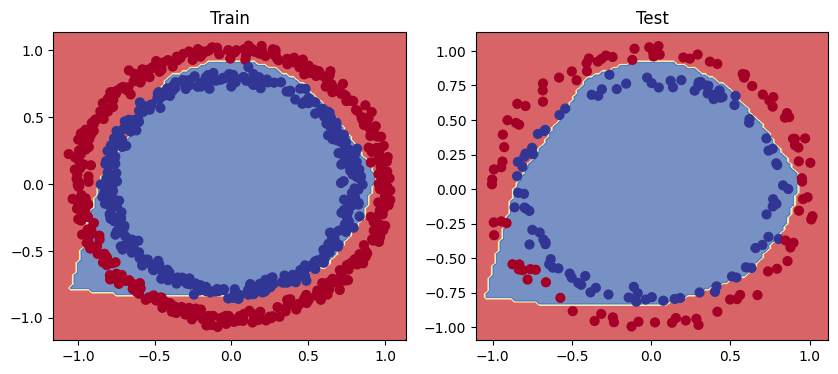

In [50]:
# Plot decision boundry of the model
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

**Challenge**: improve model_3 to do better than 80% accuracy on the test data

In [51]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV4(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=64)
        self.layer_2 = nn.Linear(in_features=64, out_features=64)
        self.layer_3 = nn.Linear(in_features=64, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_4 = CircleModelV4().to(device)
model_4

CircleModelV4(
  (layer_1): Linear(in_features=2, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

In [52]:
# Create loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params = model_4.parameters(),
                            lr=0.1)

In [53]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2. Calculate loss / accuracy

    # if the loss_fn is nn.BCELoss, we need to use this loss function:
    # loss = loss_fn(torch.sigmoid(y_logits), y_train) # nn.BCELoss expects prediction probabilities as input

    # if the loss_fn is nn.BCEWithLogitsLoss, we need to use this loss function:
    loss = loss_fn(y_logits, y_train)  # nn.BCEWithLogitsLoss expects raw logits as input

    acc = accuracy_fn(y_true = y_train,
                      y_pred = y_pred )

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_4(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate the loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_test,
                               y_pred = test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")




Epoch: 0 | Loss: 0.69179, Acc: 47.38% | Test Loss: 0.69427, Test acc: 46.50%
Epoch: 100 | Loss: 0.67966, Acc: 63.50% | Test Loss: 0.68497, Test acc: 56.00%
Epoch: 200 | Loss: 0.66168, Acc: 78.00% | Test Loss: 0.67067, Test acc: 71.00%
Epoch: 300 | Loss: 0.62306, Acc: 90.88% | Test Loss: 0.63723, Test acc: 89.50%
Epoch: 400 | Loss: 0.53367, Acc: 99.00% | Test Loss: 0.55896, Test acc: 98.00%
Epoch: 500 | Loss: 0.37491, Acc: 99.75% | Test Loss: 0.41442, Test acc: 98.50%
Epoch: 600 | Loss: 0.21174, Acc: 100.00% | Test Loss: 0.25405, Test acc: 99.50%
Epoch: 700 | Loss: 0.12633, Acc: 100.00% | Test Loss: 0.16374, Test acc: 100.00%
Epoch: 800 | Loss: 0.07601, Acc: 100.00% | Test Loss: 0.10677, Test acc: 100.00%
Epoch: 900 | Loss: 0.05125, Acc: 100.00% | Test Loss: 0.07769, Test acc: 100.00%


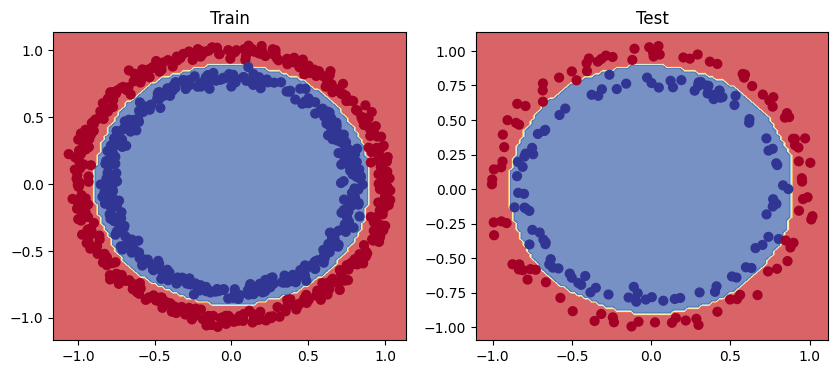

In [54]:
# Plot decision boundry of the model
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_test, y_test)

## 8. Putting it all together with a multi-class classification problem

* Binary classification = one thing or another (cat vs dog, spam vs not spam, fraud or not fraud)

* Multi-class classification = more than one thing or another (cat vs. dog vs. chicken)

### 8.1 Creating a toy multi-class dataset

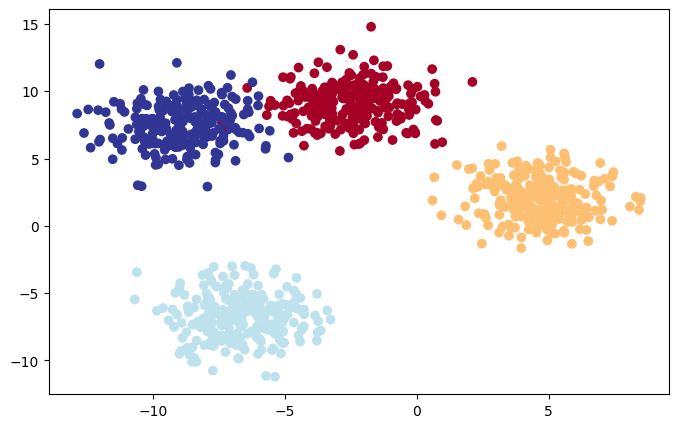

In [55]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples= 1000,
                            n_features=NUM_FEATURES,
                            centers= NUM_CLASSES,
                            cluster_std=1.5, # give the clusters a little shake up
                            random_state=RANDOM_SEED
                        )

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size= 0.2,
                                                                        random_state= RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(8, 5))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)


### 8.2 Building a multi-class classification model in PyTorch

In [56]:
# Make device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [57]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0]))

In [58]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

In [59]:
# Build a multi-class classification model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """ Initializes multi-class classification model.

        Args:
            input features (int): Number of input features to the model
            output features (int): Number of output features (number of output classes)
            hidden_units (int): Number of hidden units between layers, default 8

        Returs:

        Example:
        """

        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features = input_features, out_features = hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features = hidden_units, out_features = hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features = hidden_units, out_features = output_features),
        )

    def forward(self,x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features = 2,
                    output_features = 4,
                    hidden_units = 8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create a loss function and an optimizer for a multi-class classification model

In [60]:
# Craete a loss function for mulit-class classification - loss function measures how wrong out model's predictions are
loss_fn = nn.CrossEntropyLoss()

# Create and optimizer for multi-class classification - optimizer updates our model parameters to try and reduce the loss
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)  # learining rate is a hyperparameter you can change



### 8.4 Getting prediction probabilities for a multi-lass PyTorch model

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then to prediction labels.

Logits -> Pred probs -> Pred labels

**Logits** (raw output of the model) -> **Pred probs** (use `torch.softmax`)-> **Pred labels** (take the argmax of the prediction probabilities)

In [61]:
# Let's get some raw outputs of our model (logits)
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852],
        [ 2.0878, -1.3728,  2.1248,  2.5052],
        [ 1.8310,  0.8851,  2.1674,  0.6006],
        [ 0.1412, -1.4742, -0.0360,  1.0373],
        [ 2.9426,  0.7047,  3.3670,  1.6184],
        [-0.0645, -1.5006, -0.2666,  0.8940]])

In [62]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [63]:
# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])


tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]])
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]])


In [64]:
torch.sum(y_pred_probs[0])


tensor(1.)

In [65]:
torch.max(y_pred_probs[0])

tensor(0.3715)

In [66]:
torch.argmax(y_pred_probs[0])

tensor(3)

In [67]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([3, 3, 2, 1, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2,
        2, 2, 3, 3, 3, 3, 3, 1, 1, 2, 1, 2, 1, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3,
        3, 3, 1, 3, 3, 1, 3, 2, 3, 1, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 3, 3, 2, 3, 3, 3, 3, 2, 3, 1, 3, 3, 2, 1, 1, 3, 2, 2, 3, 3, 3, 1, 2,
        2, 3, 3, 1, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 1, 1, 3, 2, 2,
        2, 2, 3, 3, 3, 2, 2, 1, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3,
        2, 2, 2, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 2, 2, 3, 2, 2, 3, 3, 2, 2, 3, 3,
        1, 3, 2, 3, 3, 1, 2, 3])

In [68]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

### 8.5 Creating a training loop and testing loop for a multi-class PyTorch model

In [69]:
# Fit the multi-class model to the data

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # turn logits -> pred probs -> pred labels

    # 2. Calculate loss / accuracy
    loss = loss_fn(y_logits, y_blob_train)

    acc = accuracy_fn(y_true = y_blob_train,
                      y_pred = y_pred )

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        # 2. Calculate the loss/acc
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true = y_blob_test,
                               y_pred = test_preds)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")




Epoch: 0 | Loss: 1.04324, Acc: 65.50% | Test Loss: 0.57861, Test acc: 95.50%
Epoch: 10 | Loss: 0.14398, Acc: 99.12% | Test Loss: 0.13037, Test acc: 99.00%
Epoch: 20 | Loss: 0.08062, Acc: 99.12% | Test Loss: 0.07216, Test acc: 99.50%
Epoch: 30 | Loss: 0.05924, Acc: 99.12% | Test Loss: 0.05133, Test acc: 99.50%
Epoch: 40 | Loss: 0.04892, Acc: 99.00% | Test Loss: 0.04098, Test acc: 99.50%
Epoch: 50 | Loss: 0.04295, Acc: 99.00% | Test Loss: 0.03486, Test acc: 99.50%
Epoch: 60 | Loss: 0.03910, Acc: 99.00% | Test Loss: 0.03083, Test acc: 99.50%
Epoch: 70 | Loss: 0.03643, Acc: 99.00% | Test Loss: 0.02799, Test acc: 99.50%
Epoch: 80 | Loss: 0.03448, Acc: 99.00% | Test Loss: 0.02587, Test acc: 99.50%
Epoch: 90 | Loss: 0.03300, Acc: 99.12% | Test Loss: 0.02423, Test acc: 99.50%


### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [70]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0727,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2891],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5918, -18.5990,  25.5310,  17.5799],
        [  7.3142,   0.7197, -11.2017,  -1.2011]])

In [71]:
# Go from logits -> Prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)


In [72]:
# Go from pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)

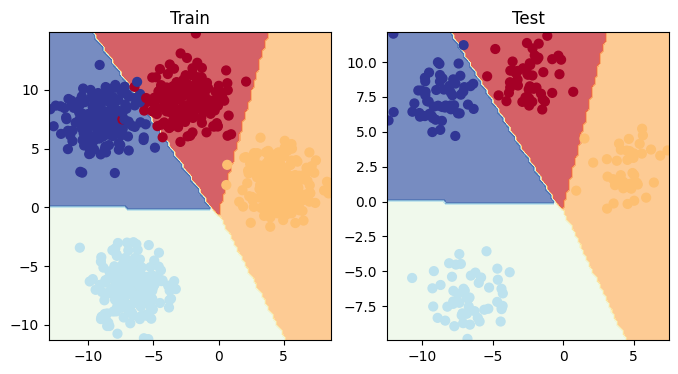

In [73]:
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classification metrics...(to evaluate our classification model)

* Accuracy
* Precision
* Recall
* F1-score
* Confucion matrix
* Classification report

In [74]:
! pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [81]:
from torchmetrics import Accuracy, Precision, Recall

# Setup metric
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9950)

In [82]:
precision = Precision(task="multiclass", average='macro', num_classes=4).to(device)
precision(y_preds, y_blob_test)

tensor(0.9950)

In [83]:
precision = Precision(task="multiclass", average='micro', num_classes=4).to(device)
precision(y_preds, y_blob_test)

tensor(0.9950)

In [84]:
recall = Recall(task="multiclass", average='macro', num_classes=4).to(device)
recall(y_preds, y_blob_test)

tensor(0.9956)

In [85]:
recall = Recall(task="multiclass", average='micro', num_classes=4).to(device)
recall(y_preds, y_blob_test)

tensor(0.9950)